# Supervised classification Workflow Example

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kshitijrajsharma/nickyspatial/blob/refs/heads/master/docs/examples/simple_usecase.ipynb)

This example explains how to perform supervised classification.

## Setup & Imports

We begin by importing the required modules and setting up the environment. & Download the sample quickbird satellite image for our module

In [1]:
# ! pip install nickyspatial
# ! pip install -e .

In [2]:
import os
import requests
import matplotlib.pyplot as plt

from nickyspatial import (
    LayerManager,
    MultiResolutionSegmentation,
    RuleSet,
    attach_ndvi,
    attach_shape_metrics,
    attach_spectral_indices,
    layer_to_raster,
    layer_to_vector,
    plot_classification,
    plot_layer,
    read_raster,
    MergeRuleSet,
    EnclosedByRuleSet,
    TouchedByRuleSet,
    SupervisedClassification
)

output_dir = "output"
os.makedirs(output_dir, exist_ok=True)


data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

raster_path = os.path.join(data_dir, "Artifical_landscape_UTM_012025.tif")

if not os.path.exists(raster_path):
    url = "https://github.com/kshitijrajsharma/nickyspatial/raw/refs/heads/master/data/sample.tif"
    print(f"Downloading sample raster from {url}...")
    response = requests.get(url)
    response.raise_for_status()  # Ensure the download succeeded
    with open(raster_path, "wb") as f:
        f.write(response.content)
    print(f"Downloaded sample raster to {raster_path}")
else:
    print(f"Using existing raster at: {raster_path}")

Using existing raster at: data/Artifical_landscape_UTM_012025.tif


## Reading the Raster

We now read the raster data and print some basic information about the image.

In [3]:
image_data, transform, crs = read_raster(raster_path)
print(f"Image dimensions: {image_data.shape}")
print(f"Coordinate system: {crs}")

Image dimensions: (3, 2937, 3061)
Coordinate system: EPSG:32633


## Performing Segmentation

Here we perform multi-resolution segmentation. A `LayerManager` is used to keep track of all layers created in the process. nickyspatial packages uses a layer object which is an underlying vector segmentation tied up to the raster , similar concept as layer in ecognition

In [4]:
manager = LayerManager()

segmenter = MultiResolutionSegmentation(scale=200, compactness=1)
segmentation_layer = segmenter.execute(
    image_data,
    transform,
    crs,
    layer_manager=manager,
    layer_name="Base_Segmentation",
)

print("Segmentation layer created:")
print(segmentation_layer)

Number of segments: 224
Segmentation layer created:
Layer 'Base_Segmentation' (type: segmentation, parent: None, objects: 110)


## Visualizing Segmentation

We utilize the built-in plotting function to visualize the segmentation. The image will be displayed inline.

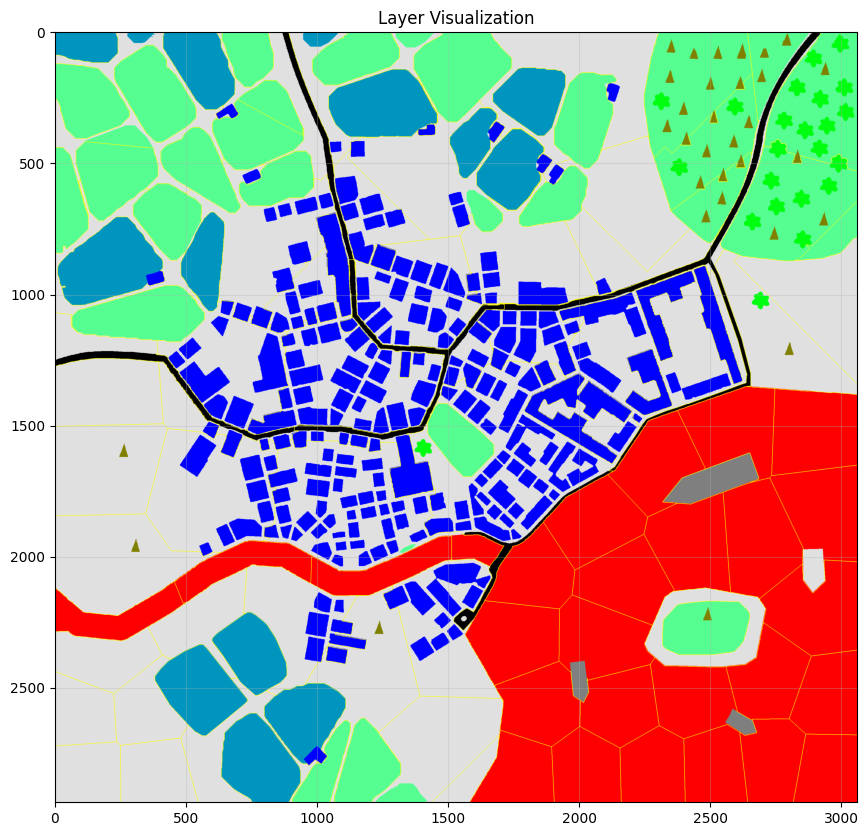

In [5]:
fig1 = plot_layer(layer=segmentation_layer, image_data=image_data, rgb_bands=(2, 1, 0), show_boundaries=True)
plt.show()

fig1.savefig(os.path.join(output_dir, "1_segmentation.png"))

In [7]:
# Samples for all eight different classes
samples={
"cropland": [11,396,489,1400,3818,1532,1470,810,594,1224,1388,13],
"meadow": [376,1040,44,2229,1099,514,65,3533,983,807],
"road": [1814,722,3303,552,2870],
"water": [3219,2005,3059,2483,4360,3108,2982,3090],
"buildings": [1937,1954,1730,2622,1912,1478,2026,1803,1864,1836],
"non_vegetated_space": [1122,1306,1872,1599,2297,1492,4027,3123,2343,2589,1235,1775,461,178,1785,2511,3250,3045,4543,1082,3812],
"deciduous": [516,1524,390,404,70],
"coniferous": [2874,558,1159,723,1773,136,235] 
}

params={"n_estimators":100, "oob_score":True, "random_state":42}
RF_classification=SupervisedClassification(name="RF Classification", classifier_type="Random Forest", classifier_params=params)
RF_classification_layer=RF_classification.execute(segmentation_layer,samples=samples,layer_manager=manager,layer_name="RF Classification",)


OOB Score: 0.4
Index(['segment_id', 'area_pixels', 'area_units', 'geometry', 'band_1_mean',
       'band_1_std', 'band_1_min', 'band_1_max', 'band_1_median',
       'band_2_mean', 'band_2_std', 'band_2_min', 'band_2_max',
       'band_2_median', 'band_3_mean', 'band_3_std', 'band_3_min',
       'band_3_max', 'band_3_median', 'classification'],
      dtype='object')


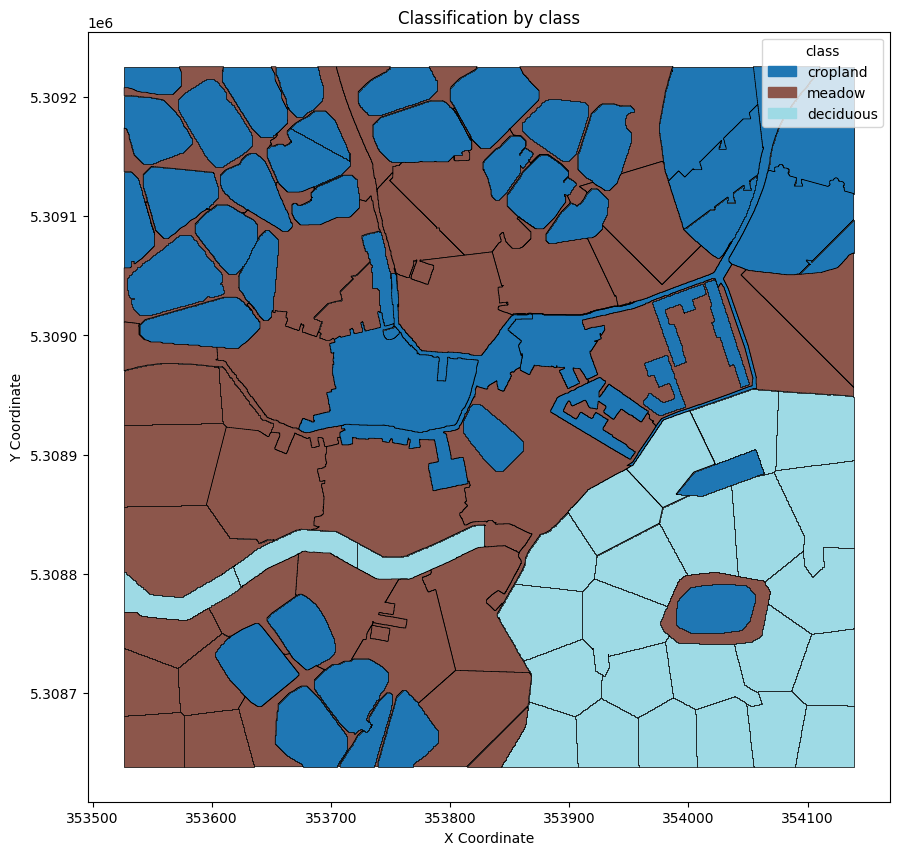

In [11]:

fig4 = plot_classification(RF_classification_layer, class_field="class")

plt.show()

In [10]:
RF_classification_layer.objects

,segment_id,area_pixels,area_units,geometry,band_1_mean,band_1_std,band_1_min,band_1_max,band_1_median,band_2_mean,...,band_2_min,band_2_max,band_2_median,band_3_mean,band_3_std,band_3_min,band_3_max,band_3_median,classification,class
0,1,25364,1014.56,"POLYGON ((353526.5 5309225.474, 353526.5 53092...",192.447563,3.816973,192.0,225.0,192.0,151.017190,...,150.0,225.0,150.0,3.051569,26.024815,0.0,225.0,0.0,,cropland
1,2,73621,2944.84,"POLYGON ((353572.9 5309225.474, 353572.9 53092...",207.541585,31.673611,146.0,255.0,225.0,227.458606,...,0.0,255.0,225.0,186.549381,68.963419,0.0,225.0,225.0,,meadow
2,3,55068,2202.72,"POLYGON ((353609.9 5309225.474, 353609.9 53092...",192.189366,2.492632,192.0,225.0,192.0,150.430377,...,150.0,225.0,150.0,1.291131,16.995218,0.0,225.0,0.0,,cropland
3,4,67013,2680.52,"POLYGON ((353649.9 5309225.474, 353649.9 53092...",164.178592,100.611191,0.0,255.0,225.0,155.315014,...,0.0,255.0,225.0,152.695223,104.179521,0.0,225.0,225.0,,meadow
4,5,31085,1243.40,"POLYGON ((353653.9 5309225.474, 353653.9 53092...",147.092810,9.227012,146.0,225.0,146.0,254.585009,...,225.0,255.0,255.0,88.908959,16.118072,87.0,225.0,87.0,,cropland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,106,60346,2413.84,"POLYGON ((353865.9 5308693.074, 353865.9 53086...",0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,255.000000,0.000000,255.0,255.0,255.0,,deciduous
106,107,57420,2296.80,"POLYGON ((354098.9 5308689.874, 354098.9 53086...",0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,255.000000,0.000000,255.0,255.0,255.0,,deciduous
107,108,21795,871.80,"POLYGON ((353864.7 5308688.674, 353864.7 53086...",221.923606,26.128995,0.0,225.0,225.0,221.923606,...,0.0,225.0,225.0,225.410186,3.483866,225.0,255.0,225.0,,meadow
108,109,60693,2427.72,"POLYGON ((353621.5 5308686.874, 353621.5 53086...",225.000000,0.000000,225.0,225.0,225.0,225.000000,...,225.0,225.0,225.0,225.000000,0.000000,225.0,225.0,225.0,,meadow
